Epoch [1/50], Step [100/938], D Loss: 0.6737, G Loss: 1.0781, C Loss: -0.5561
FID: 646.3960
Epoch [1/50], Step [200/938], D Loss: 0.5147, G Loss: 1.0884, C Loss: -0.4572
FID: 629.6238
Epoch [1/50], Step [300/938], D Loss: 1.1323, G Loss: 4.0433, C Loss: -0.8733
FID: 539.4003
Epoch [1/50], Step [400/938], D Loss: 0.0564, G Loss: 6.2846, C Loss: -0.0306
FID: 1119.1566
Epoch [1/50], Step [500/938], D Loss: 0.0132, G Loss: 5.4450, C Loss: -0.0070
FID: 698.2001
Epoch [1/50], Step [600/938], D Loss: 0.0215, G Loss: 5.4982, C Loss: -0.0120
FID: 791.9681
Epoch [1/50], Step [700/938], D Loss: 0.0258, G Loss: 5.8234, C Loss: -0.0194
FID: 993.8335
Epoch [1/50], Step [800/938], D Loss: 0.2090, G Loss: 6.5350, C Loss: -0.0619
FID: 692.0970
Epoch [1/50], Step [900/938], D Loss: 0.0247, G Loss: 6.9604, C Loss: -0.0044
FID: 682.5984
Epoch [2/50], Step [100/938], D Loss: 0.0333, G Loss: 6.9463, C Loss: -0.0164
FID: 698.4067
Epoch [2/50], Step [200/938], D Loss: 0.0316, G Loss: 6.8694, C Loss: -0.0169
F

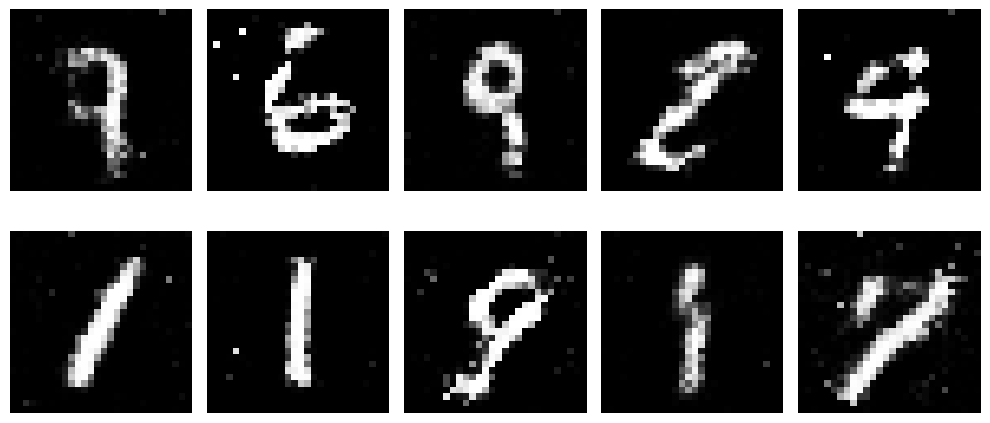

In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Correlation device is a simple neural network that takes a signal as input and outputs a probability distribution
class CorrelationDevice(nn.Module):
    def __init__(self, signal_dim):
        super(CorrelationDevice, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(signal_dim, 128),
            nn.ReLU(),
            nn.Linear(128, signal_dim),
            nn.Softmax(dim=-1)  # Assuming a categorical signal
        )
        
    def forward(self, signal):
        return self.main(signal)

class Generator(nn.Module):
    def __init__(self, input_dim, signal_dim, output_dim):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(input_dim + signal_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, output_dim),
            nn.Tanh()  # Assuming the output is a normalized image
        )
        
    def forward(self, noise, signal):
        combined_input = torch.cat((noise, signal), 1)
        return self.main(combined_input)

# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim, signal_dim):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(input_dim + signal_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Output probability of being real
        )
        
    def forward(self, sample, signal):
        combined_input = torch.cat((sample, signal), 1)
        return self.main(combined_input)

# Parameters
batch_size = 64
signal_dim = 10
noise_dim = 100  # size of the g's input noise vector
image_dim = 28*28  # flatten MNIST
learning_rate = 0.0002

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize MNIST 
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

C = CorrelationDevice(signal_dim=signal_dim)
G = Generator(input_dim=noise_dim, signal_dim=signal_dim, output_dim=image_dim)
D = Discriminator(input_dim=image_dim, signal_dim=signal_dim)

optimizer_C = optim.Adam(C.parameters(), lr=learning_rate)
optimizer_G = optim.Adam(G.parameters(), lr=learning_rate)
optimizer_D = optim.Adam(D.parameters(), lr=learning_rate)

# Training Loop
num_epochs = 50
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def difficulty_ramp(difficulty, max_difficulty, growth_rate):
    # A logistic growth function to increase difficulty
    return max_difficulty / (1 + np.exp(-growth_rate * (difficulty - max_difficulty/2)))

C.to(device)
G.to(device)
D.to(device)

adversarial_loss = torch.nn.BCELoss()

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        batch_size = real_images.size(0)
        real_images = real_images.view(batch_size, -1).to(device) # flatten

        # create labels for real and fake
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # generate random noise + signals
        noise = torch.randn(batch_size, noise_dim, device=device)
        signals = torch.randn(batch_size, signal_dim, device=device)
        correlated_signals = C(signals)

        # use G to get fake images
        fake_images = G(noise, correlated_signals.detach())

        # D train
        D_real = D(real_images, correlated_signals.detach())
        D_fake = D(fake_images, correlated_signals.detach())
        D_loss_real = adversarial_loss(D_real, real_labels)
        D_loss_fake = adversarial_loss(D_fake, fake_labels)
        D_loss = D_loss_real + D_loss_fake

        optimizer_D.zero_grad()
        D_loss.backward()
        optimizer_D.step()

        # G train
        correlated_signals = C(signals)
        fake_images = G(noise, correlated_signals)
        D_fake = D(fake_images, correlated_signals)
        G_loss = adversarial_loss(D_fake, real_labels)

        optimizer_G.zero_grad()
        G_loss.backward()
        optimizer_G.step()

        # C train
        # Using assumption that improving G's performance is beneficial for C
        # apply difficulty ramp to gradually increase difficulty
        difficulty = difficulty_ramp(epoch * len(dataloader) + i, max_difficulty=1.0, growth_rate=0.05)
        signals = torch.randn(batch_size, signal_dim, device=device) * difficulty
        correlated_signals = C(signals)
        fake_images = G(noise, correlated_signals)
        D_fake = D(fake_images, correlated_signals)
        C_loss = -adversarial_loss(D_fake, fake_labels) 

        optimizer_C.zero_grad()
        C_loss.backward()
        optimizer_C.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], '
                  f'D Loss: {D_loss.item():.4f}, G Loss: {G_loss.item():.4f}, C Loss: {C_loss.item():.4f}')
        
        # FID calculation for generated MNIST images
        if (i+1) % 100 == 0:
            mu1, sigma1 = torch.mean(real_images, dim=0), torch.std(real_images, dim=0)
            mu2, sigma2 = torch.mean(fake_images, dim=0), torch.std(fake_images, dim=0)
            FID = ((mu1 - mu2)**2 + (sigma1 - sigma2)**2).sum().item()
            print(f'FID: {FID:.4f}')
        

def show_generated_images(generator, correlation_device, noise_dim, signal_dim, num_images=10):
    noise = torch.randn(num_images, noise_dim, device=device)
    signals = torch.randn(num_images, signal_dim, device=device)
    with torch.no_grad():
        correlated_signals = correlation_device(signals)
        generated_images = generator(noise, correlated_signals).cpu().view(num_images, 28, 28)

    plt.figure(figsize=(10, 5))
    for i, image in enumerate(generated_images):
        plt.subplot(2, num_images//2, i+1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_generated_images(G, C, noise_dim, signal_dim)